In [1]:
from wrapper_functions import *

2023-04-19 10:10:28.342807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2023-04-19 10:10:57.853121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)

# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = 0.725 # @param
bma_gp_l2_regularizer = .05 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param

# BNE parameter
bne_gp_lengthscale = 2.6 # 5. # @param
bne_gp_l2_regularizer = 4.95  # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


### Read training/prediction data

In [3]:
#training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA = pd.read_csv('../data/training_dataset/training51_kmeans6.csv')
training_eastMA_noMI = training_eastMA[:51]
#training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


#training51 = pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

(51, 8)

(84421, 5)

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 43.629605 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


TensorShape([51, 3])

TensorShape([84421, 3])

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

**Prepare Data Dict**

In [4]:
data_dicts = dict(X_train = X_train1,
                  X_test=X_test1,
                  Y_train = Y_train,
                  base_preds_train = base_preds_train,
                  base_preds_test = base_preds_test)

In [5]:
bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)

bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

In [6]:
bma_config

{'gp_lengthscale': 0.725,
 'gp_l2_regularizer': 0.05,
 'y_noise_std': 0.01,
 'map_step_size': 0.0005,
 'map_num_steps': 10000,
 'mcmc_step_size': 0.0001,
 'mcmc_num_steps': 1000,
 'mcmc_initialize_from_map': False,
 'n_samples_eval': 250,
 'n_samples_train': 100,
 'n_samples_test': 250,
 'seed': 0}

In [7]:
def get_bne_result(data_dict, moment_mode, bne_config):
  """Trains Bayesian nonparametric ensemble."""
  mode_to_name_map = {'none': 'bma', 'mean': 'bae', 
                      'variance': 'bne_var', 'skewness': 'bne_skew'}
  model_name = mode_to_name_map[moment_mode]

  joint_samples = run_bne_model(X_train=data_dict['X_train_mcmc'], 
                                Y_train=data_dict['Y_train_mcmc'], 
                                X_test=data_dict['X_test'],
                                base_model_samples_train=data_dict['means_train_mcmc'],
                                base_model_samples_test=data_dict['means_test_mcmc'],
                                moment_mode=moment_mode,
                                **bne_config)
  
  #data_dict[f'{model_name}_samples'] = joint_samples['y']
  #return data_dict
  return joint_samples

# @title Simulation: get_bma_result
def get_bma_result(data_dict, bma_config):
  """Trains Adaptive Bayesian model averaging."""
  (bma_joint_samples, X_train_mcmc, Y_train_mcmc, 
   means_train_mcmc, means_test_mcmc) = run_bma_model(
       X_train=data_dict["X_train"], 
       X_test=data_dict["X_test"], 
       Y_train=data_dict["Y_train"], 
       base_preds_train=data_dict["base_preds_train"], 
       base_preds_test=data_dict["base_preds_test"], 
       return_mcmc_examples=True,
       **bma_config)

  data_dict['X_train_mcmc'] = X_train_mcmc
  data_dict['Y_train_mcmc'] = Y_train_mcmc
  data_dict['means_train_mcmc'] = means_train_mcmc
  data_dict['means_test_mcmc'] = means_test_mcmc
  data_dict['bma_mean_samples'] = bma_joint_samples['y']
  # data_dict['bma_mean_samples_original'] = bma_joint_samples['mean_original']
  # data_dict['bma_mean_samples_resid'] = bma_joint_samples['resid']
  # data_dict['bma_weight_samples'] = bma_joint_samples['weights']

  return data_dict, bma_joint_samples


def calc_prediction_std(y_pred, y):
  """
  This function takes two arguments:
  y_pred: a TensorFlow tensor containing the predicted values of the response variable
  y: a TensorFlow tensor containing the observed values of the response variable
  The function calculates the residuals, mean, variance, and standard deviation of the residuals using TensorFlow operations and returns the standard deviation as a TensorFlow tensor.
  To use this function, you will need to pass in the appropriate tensors as arguments and execute the TensorFlow graph to calculate the standard deviation.
  """
  # Calculate the residuals
  residuals = y - y_pred

  # Calculate the mean of the residuals
  mean = tf.reduce_mean(residuals)
  # change tf.int32 to tf.float32
  mean = tf.cast(mean, tf.float32)
  df = tf.cast(tf.size(residuals) - 1, tf.float32)
  # Calculate the variance of the residuals
  variance = tf.reduce_sum(tf.square(residuals - mean)) / df

  # Calculate the standard deviation of the residuals
  std = tf.sqrt(variance)

  return std


In [8]:
def posterior_heatmap_2d_tr(plot_data, X,
                         X_monitor=None,
                         cmap='inferno_r',
                         norm=None, 
                         norm_method="percentile",
                         save_addr=''):
    
    plt.scatter(x=X[:, 0], y=X[:, 1],
                s=3,
                c=plot_data, cmap=cmap, norm=norm)
    cbar = plt.colorbar()

    plt.scatter(X_tr[:, 0] * X_scale[0] + X_centr[0], X_tr[:, 1] * X_scale[1] +
                X_centr[1], c="black", s=10, alpha=0.5, marker="s")  # different shape
    plt.scatter(X_te[:, 0] * X_scale[0] + X_centr[0], X_te[:, 1] * X_scale[1] + X_centr[1], c="blue",
                s=abs(nll_bae_each)*50)
                #, cmap='inferno_r', norm=color_norm_nll_each)

    # adjust plot window
    plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))

    return norm

In [9]:
spcv_id = training_eastMA_noMI["fold"]


1
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6628925800323486
activation function used softmax
activation function used softmax
activation function used softmax
[[6.6400847]
 [8.398089 ]
 [5.1118584]
 [5.989453 ]
 [9.105975 ]
 [7.399893 ]]
BMA:


/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.


Running MCMC:	Acceptance Ratio: 0.8250645399093628
[[6.684774]
 [8.417217]
 [5.076655]
 [5.951228]
 [9.110726]
 [7.405938]]
BAE:
Running MAP:	292427.3125...65882.015625...32614.865234375...19250.09375...12090.5458984375...7948.55126953125...5566.93701171875...4263.912109375...3615.818603515625...3341.359375...Done.
Running MCMC:	Acceptance Ratio: 0.7819749712944031
[[10.813478 ]
 [11.86619  ]
 [ 4.1731534]
 [ 6.4181147]
 [ 9.913313 ]
 [ 6.470214 ]]


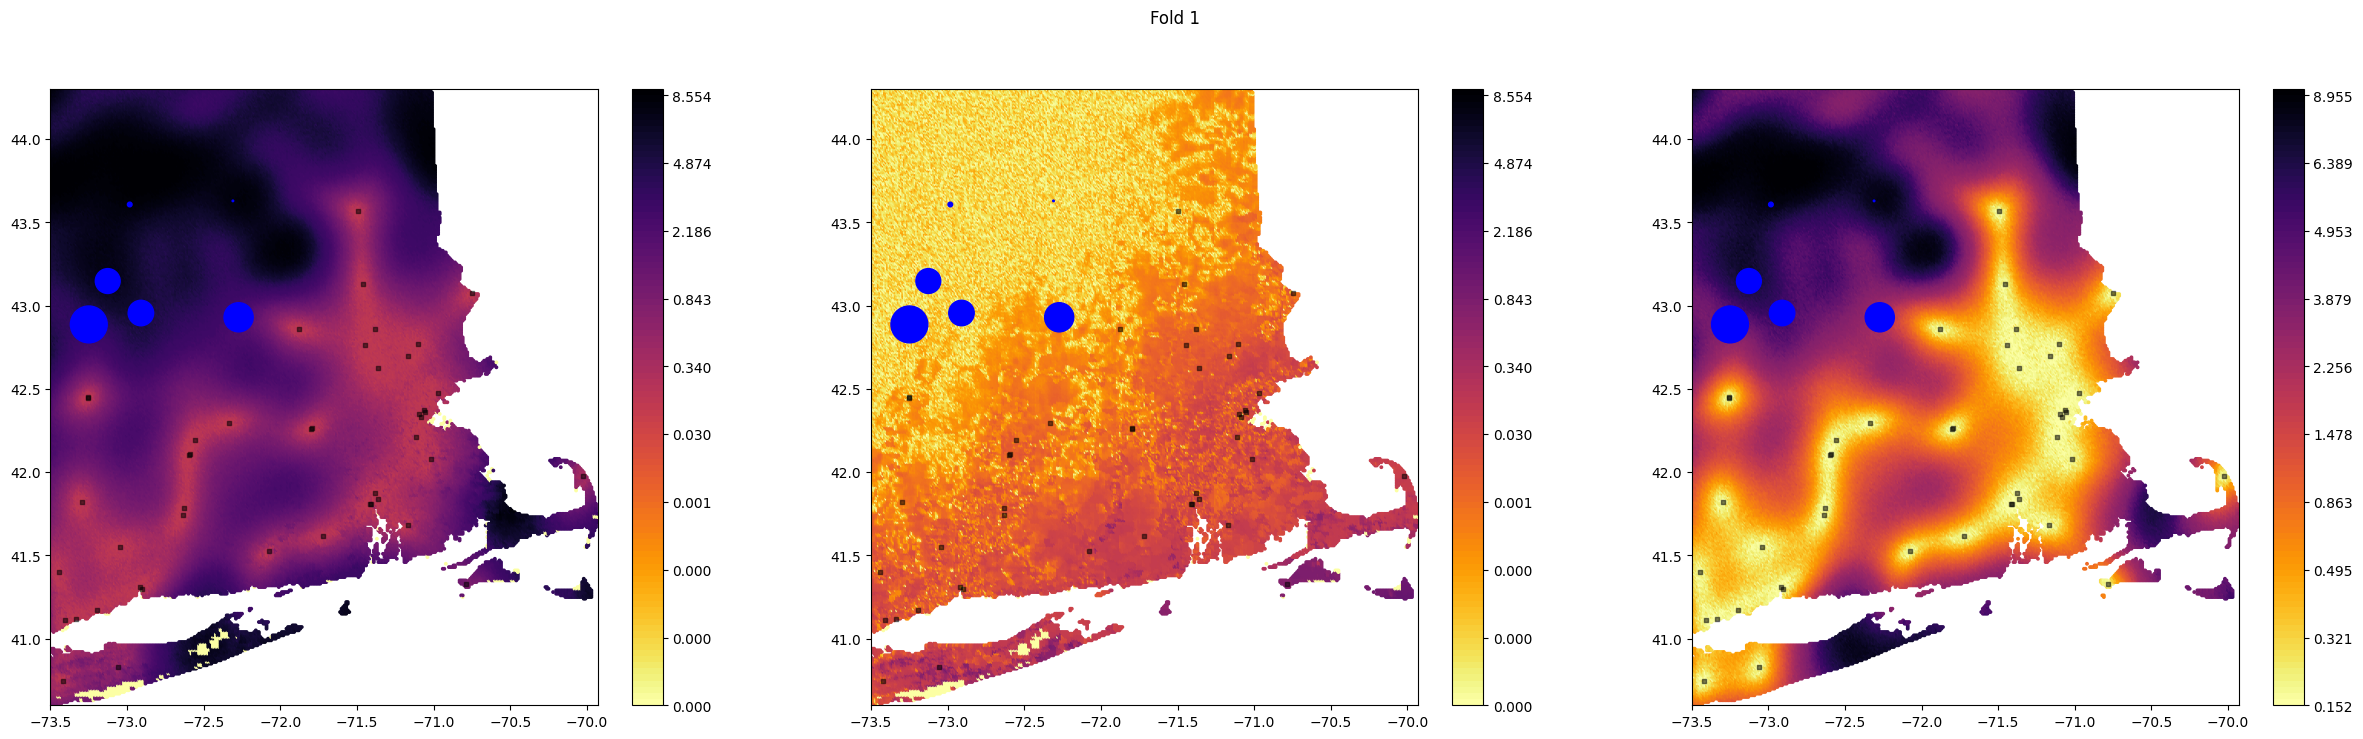

2
(41, 2) (10, 2) (41, 1) (10, 1) (41, 3) (10, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.21196110546588898
activation function used softmax
activation function used softmax
activation function used softmax
[[8.259956 ]
 [8.525593 ]
 [6.5148106]
 [7.884229 ]
 [8.884005 ]
 [8.884245 ]
 [9.1834955]
 [9.038338 ]
 [8.752572 ]
 [8.305906 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.7572499513626099
[[8.287776 ]
 [8.547477 ]
 [6.4460387]
 [8.031698 ]
 [9.016051 ]
 [8.992094 ]
 [9.169294 ]
 [9.1025505]
 [8.666463 ]
 [8.248831 ]]
BAE:
Running MAP:	358537.53125...81704.6484375...36535.70703125...20902.25390625...13222.1494140625...8787.26171875...6120.26318359375...4562.423828125...3718.697998046875...3314.968994140625...Done.
Running MCMC:	Acceptance Ratio: 0.8083266019821167
[[ 9.548756 ]
 [11.50109  ]
 [ 6.155922 ]
 [ 2.4233553]
 [ 1.8407694]
 [ 1.764821 ]
 [ 1.5650669]
 [ 1.522041 ]
 [ 9.740582 ]
 [ 9.319135 ]]


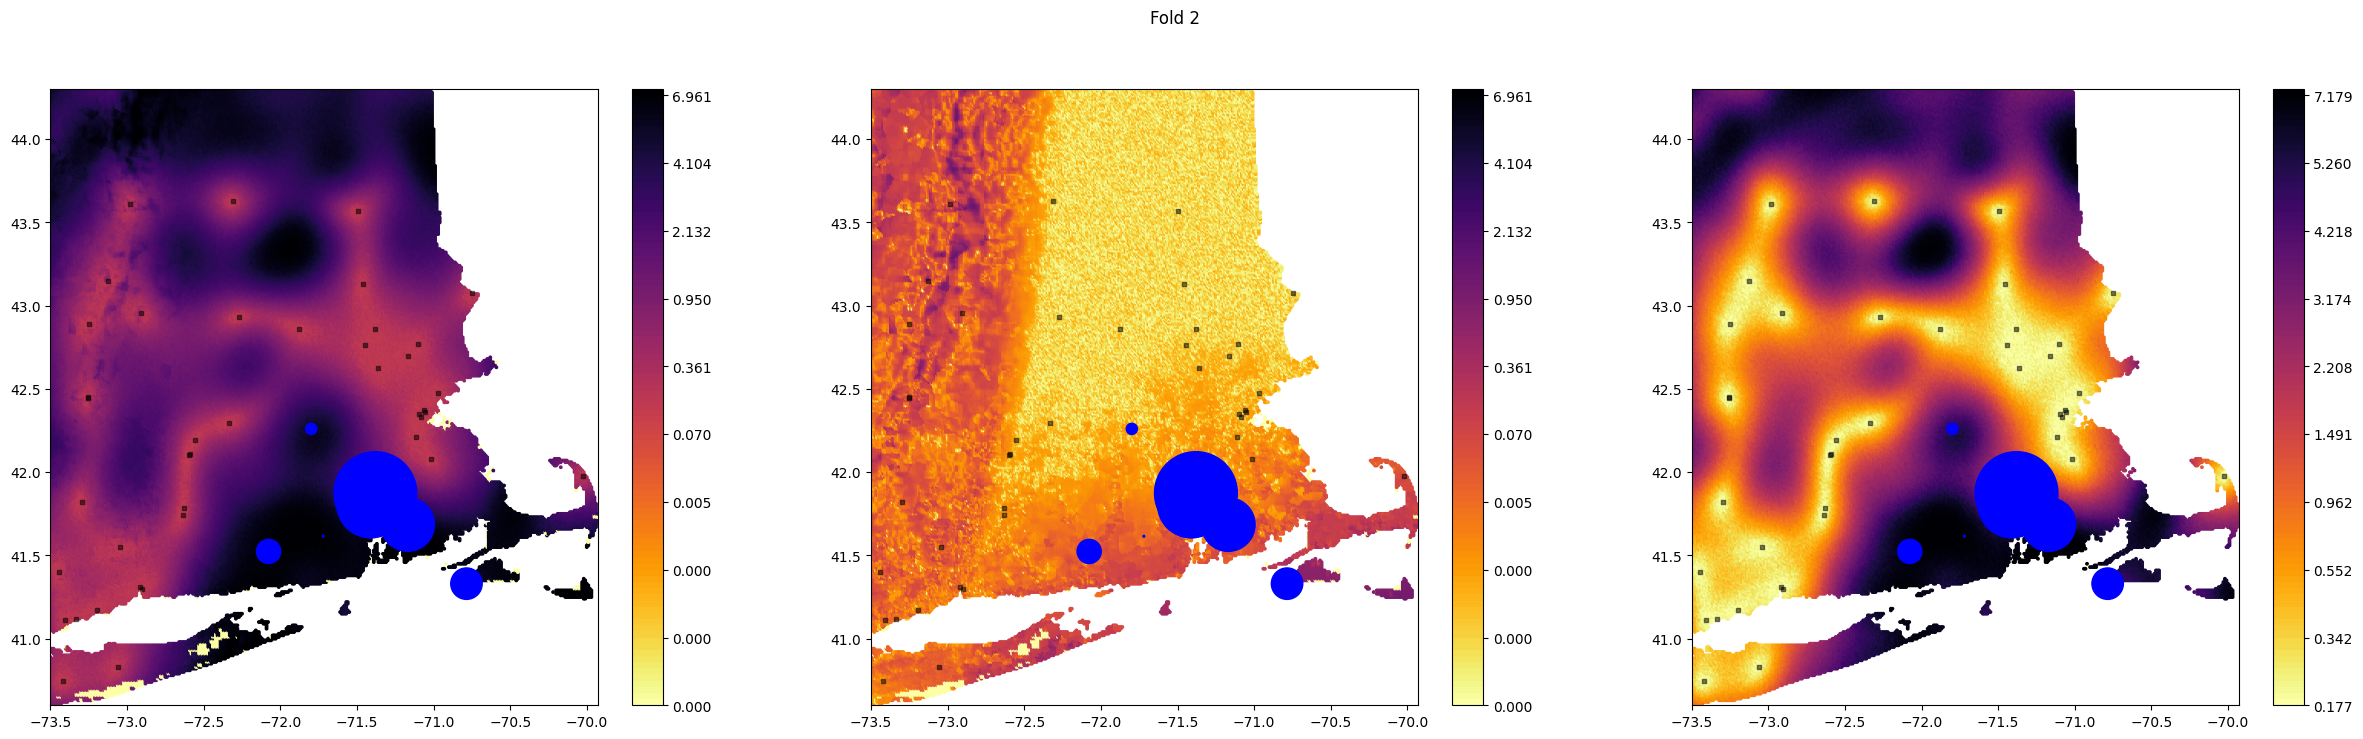

3
(43, 2) (8, 2) (43, 1) (8, 1) (43, 3) (8, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.7493286728858948
activation function used softmax
activation function used softmax
activation function used softmax
[[5.372671 ]
 [8.902951 ]
 [7.908413 ]
 [9.1430435]
 [9.050128 ]
 [8.596111 ]
 [9.32011  ]
 [8.677254 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.6486856937408447
[[5.3712745]
 [8.8666935]
 [7.9275026]
 [9.183473 ]
 [8.936071 ]
 [8.658281 ]
 [9.287751 ]
 [8.67061  ]]
BAE:
Running MAP:	250247.65625...45981.8828125...17916.0859375...9422.759765625...5801.57666015625...3929.123779296875...2888.90673828125...2335.018798828125...2076.021240234375...1971.34619140625...Done.
Running MCMC:	Acceptance Ratio: 0.75031977891922
[[ 3.7319024]
 [10.81744  ]
 [12.720839 ]
 [12.407965 ]
 [12.037946 ]
 [10.951657 ]
 [11.545963 ]
 [ 7.985327 ]]


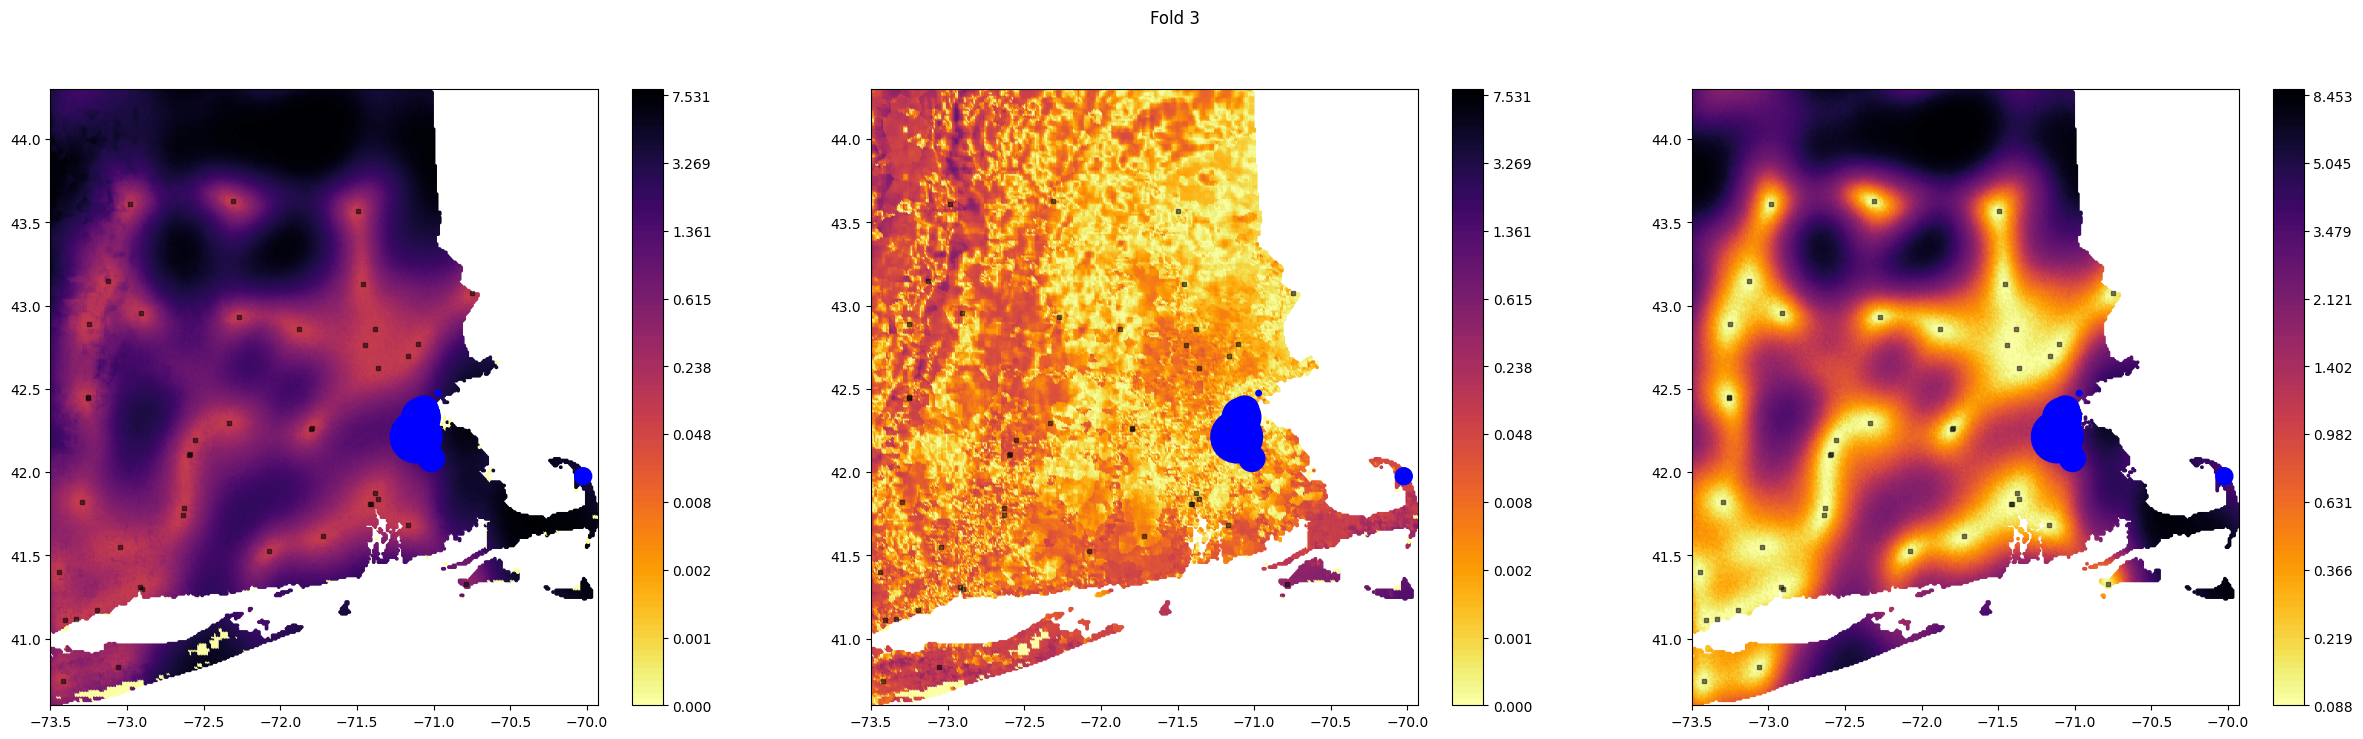

4
(42, 2) (9, 2) (42, 1) (9, 1) (42, 3) (9, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.558964729309082
activation function used softmax
activation function used softmax
activation function used softmax
[[10.010751]
 [10.027067]
 [ 6.334532]
 [ 9.819932]
 [ 9.891902]
 [ 9.85946 ]
 [ 6.817448]
 [ 8.811965]
 [ 8.267362]]
BMA:
Running MCMC:	Acceptance Ratio: 0.799668550491333
[[10.077177]
 [10.014404]
 [ 6.187788]
 [ 9.811509]
 [ 9.930381]
 [ 9.957578]
 [ 6.837174]
 [ 8.861393]
 [ 8.247645]]
BAE:
Running MAP:	191653.65625...39835.01171875...17396.537109375...10019.6875...6497.4560546875...4536.36181640625...3447.82275390625...2898.482421875...2665.873046875...2589.556396484375...Done.
Running MCMC:	Acceptance Ratio: 0.7209409475326538
[[ 9.628433 ]
 [10.016576 ]
 [ 7.1351275]
 [ 9.399221 ]
 [ 9.377947 ]
 [ 8.345264 ]
 [ 1.9751325]
 [ 8.022639 ]
 [ 7.408755 ]]


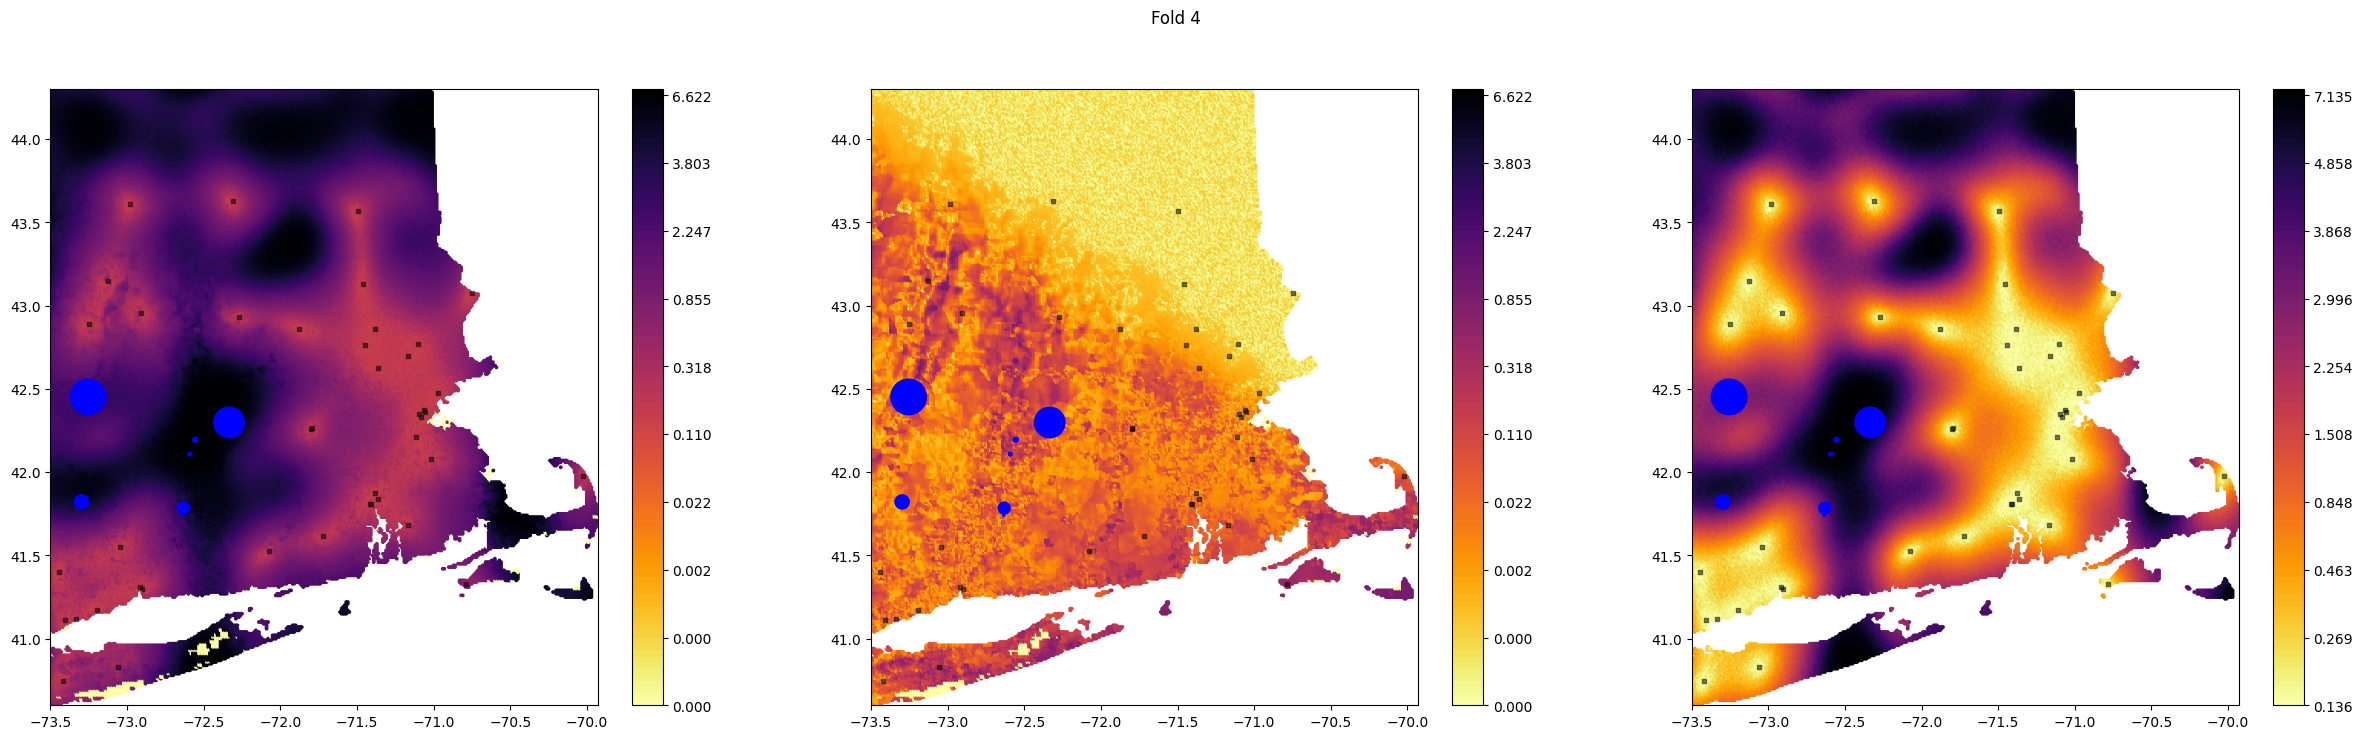

5
(42, 2) (9, 2) (42, 1) (9, 1) (42, 3) (9, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.779944658279419
activation function used softmax
activation function used softmax
activation function used softmax
[[8.442694 ]
 [8.81526  ]
 [8.48111  ]
 [7.814067 ]
 [5.5248027]
 [6.999464 ]
 [7.351048 ]
 [7.7746053]
 [6.7613816]]
BMA:
Running MCMC:	Acceptance Ratio: 0.7990895509719849
[[8.52015  ]
 [8.800851 ]
 [8.309774 ]
 [7.804114 ]
 [5.569429 ]
 [7.1141343]
 [7.3743563]
 [7.832225 ]
 [6.7386894]]
BAE:
Running MAP:	229346.421875...49497.33203125...22283.716796875...13161.265625...8639.8974609375...6051.70751953125...4569.51123046875...3780.593017578125...3414.0625...3276.0478515625...Done.
Running MCMC:	Acceptance Ratio: 0.6283522248268127
[[8.552916 ]
 [8.58565  ]
 [8.441043 ]
 [6.5914783]
 [4.443245 ]
 [6.5714126]
 [4.0270953]
 [8.976939 ]
 [4.164434 ]]


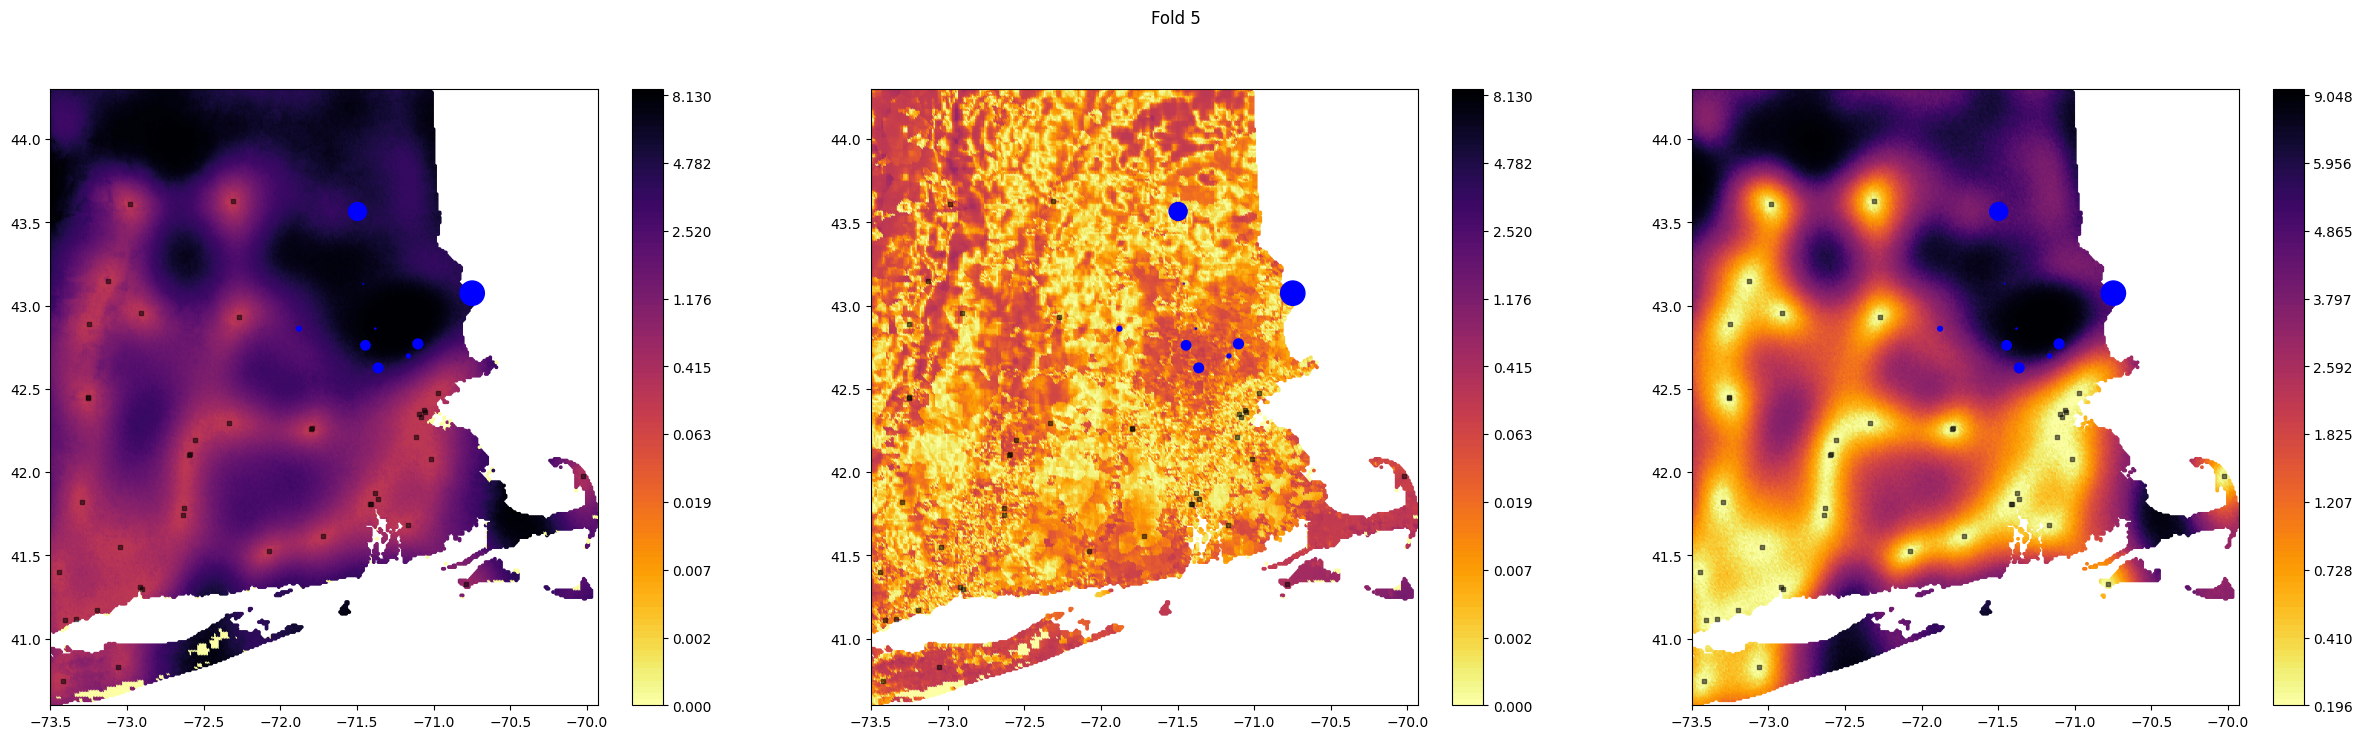

6
(42, 2) (9, 2) (42, 1) (9, 1) (42, 3) (9, 3)
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.8014096021652222
activation function used softmax
activation function used softmax
activation function used softmax
[[ 9.435931 ]
 [10.22383  ]
 [10.255178 ]
 [ 9.501619 ]
 [ 9.9485445]
 [ 9.678725 ]
 [ 9.699311 ]
 [ 9.393701 ]
 [ 9.908676 ]]
BMA:
Running MCMC:	Acceptance Ratio: 0.7990712523460388
[[ 9.516457 ]
 [10.208919 ]
 [10.0769615]
 [ 9.4912615]
 [ 9.994943 ]
 [ 9.797987 ]
 [ 9.723626 ]
 [ 9.453638 ]
 [ 9.885133 ]]
BAE:
Running MAP:	406238.3125...92028.0...40456.74609375...22848.884765625...14328.6494140625...9457.44921875...6529.68994140625...4803.7841796875...3852.35595703125...3386.39013671875...Done.
Running MCMC:	Acceptance Ratio: 0.8122177124023438
[[10.111996]
 [12.771529]
 [ 9.01952 ]
 [ 8.151793]
 [ 9.007096]
 [12.442272]
 [12.385955]
 [10.261205]
 [11.232075]]


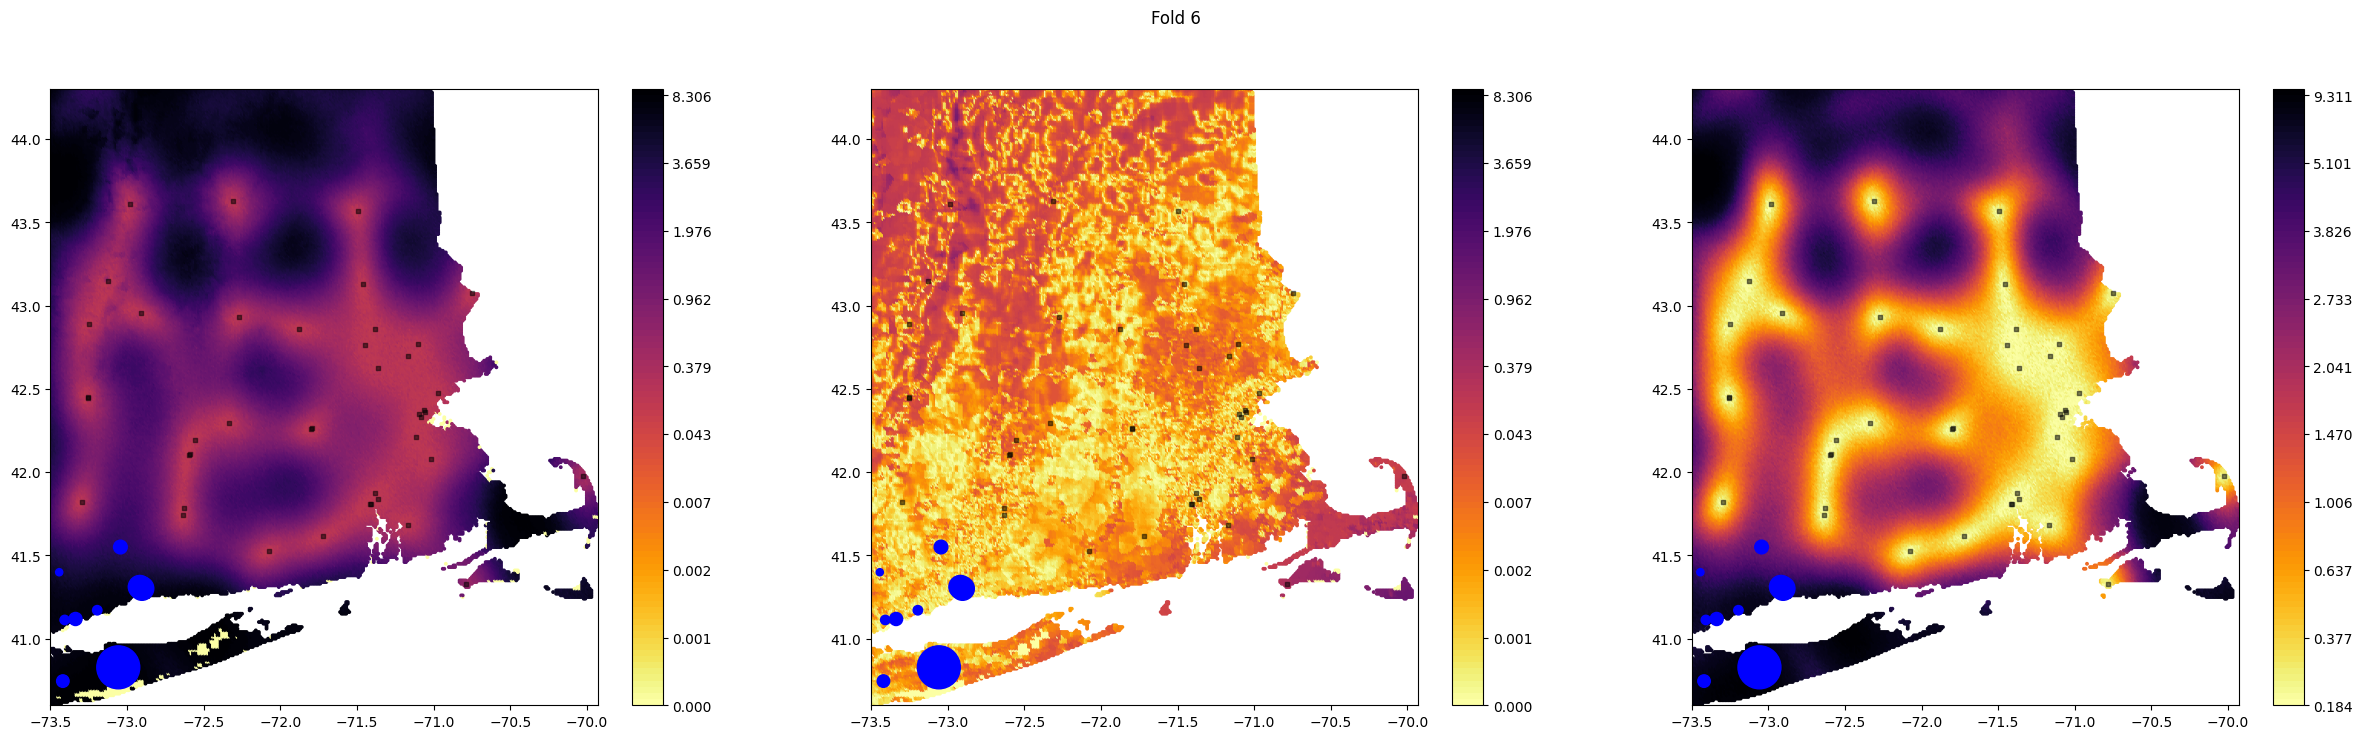

In [51]:
monitors = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)

nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each = [], [], [], [], []

for fold_id in range(1,7):
    print(fold_id)
    X_tr, X_te = X_train1[spcv_id!=fold_id], X_train1[spcv_id==fold_id]
    Y_tr, Y_te = Y_train[spcv_id!=fold_id], Y_train[spcv_id==fold_id]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[spcv_id!=fold_id], base_preds_train.numpy()[spcv_id==fold_id]
    X_test_long = np.vstack((X_test1, X_te))
    base_preds_test_long = np.vstack((base_preds_test.numpy(), base_preds_te))

    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape, base_preds_tr.shape, base_preds_te.shape)

    # Create data dictionaryx
    data_dicts = dict(X_train=X_tr,
                      X_test=X_test_long,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_test_long)

    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(bma_mean_joint_samples['y']), axis=0)
    y_pred_bma_mean = y_pred_bma_mean[84421:]
    print(y_pred_bma_mean)
    pred_var_bma_mean = calc_prediction_std(y_pred_bma_mean, Y_te)
    nll_bma_mean_each = (y_pred_bma_mean - Y_te)**2

    surface_pred_bma = np.nanmean(data_dict['bma_mean_samples'], axis=0)
    surface_var_bma = np.nanvar(data_dict['bma_mean_samples'], axis=0)

    # BMA.
    print('BMA:', flush=True)
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    y_pred_bma = y_pred_bma[84421:]
    print(y_pred_bma)
    pred_var_bma = calc_prediction_std(y_pred_bma, Y_te)
    nll_bma_each = (y_pred_bma - Y_te)**2

    surface_pred_bma = {k: np.mean(np.nan_to_num(
        bma_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
    surface_var_bma = {k: np.var(np.nan_to_num(
        bma_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

    # BAE.
    print('BAE:', flush=True)
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    y_pred_bae = y_pred_bae[84421:]
    print(y_pred_bae)
    pred_var_bae = calc_prediction_std(y_pred_bae, Y_te)
    nll_bae_each = (y_pred_bae - Y_te)**2

    surface_pred_bae = {k: np.mean(np.nan_to_num(
        bae_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
    surface_var_bae = {k: np.var(np.nan_to_num(
        bae_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}


    # # larger points are more error
    coordinate = np.asarray(base_model_predictions_eastMA[[
        "lon", "lat"]].values.tolist()).astype(np.float32)

    nll_list = [nll_bma_mean_each, nll_bma_each, nll_bae_each]
    nll_list = np.asarray(nll_list)
    nll_list = nll_list.reshape(-1, len(nll_bma_mean_each)*3)
    j = 1
    plt.figure(figsize=(30, 8))
    # BAE
    color_norm_var = make_color_norm(
        list(surface_var_bae.values())[:2],
        method="percentile")

    color_norm_var_r = make_color_norm(
        list(surface_var_bae.values())[2],
        method="percentile")

    for name, value in surface_var_bae.items():
        plt.subplot(1, 3, j)
        save_name = os.path.join(_SAVE_ADDR_PREFIX,
                                 'var_BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}_fold_{}.png'.format(
                                     name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                     bne_gp_lengthscale, bne_gp_l2_regularizer, fold_id))

        j += 1
        posterior_heatmap_2d_tr(value[:84421], X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm=color_norm_var_r if name == 'resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

    plt.suptitle("Fold " + str(fold_id))
    plt.show()


    

In [21]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')

mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')

# storage prepared
rmse_lr, rmse_gam, rmse_bma_mean, rmse_bma, rmse_bae = [], [], [], [], []
nll_lr, nll_gam, nll_bma_mean, nll_bma, nll_bae = [], [], [], [], []
coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0

rmse_ensemble1, rmse_ensemble2, rmse_ensemble3, rmse_ensemble4 = [], [], [], []
nll_ensemble1, nll_ensemble2, nll_ensemble3, nll_ensemble4 = [], [], [], []
coverage_ensemble1, coverage_ensemble2, coverage_ensemble3, coverage_ensemble4 = 0, 0, 0, 0

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)

for fold_id in range(1,7):
    print(fold_id)
    X_tr, X_te = X_train1[spcv_id!=fold_id], X_train1[spcv_id==fold_id]
    Y_tr, Y_te = Y_train[spcv_id!=fold_id], Y_train[spcv_id==fold_id]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[spcv_id!=fold_id], base_preds_train.numpy()[spcv_id==fold_id]
    X_test_long = np.vstack((X_test1, X_te))
    base_preds_test_long = np.vstack((base_preds_test.numpy(), base_preds_te))

    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py[spcv_id!=fold_id])
        r_te = ro.conversion.py2rpy(r_dat_py[spcv_id==fold_id])

    # Ref: lr
    lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[8]
    lr_predV = np.asanyarray(lr_pred).reshape(-1, 1)
    lr_ci_l, lr_ci_u = l[9], l[10]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) & (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, lr_predV))
    nll_lr.append(nll(Y_te, lr_predV))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[8]
    gam_predV = np.asanyarray(gam_pred).reshape(-1, 1)
    gam_ci_l, gam_ci_u = a[9], a[10]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) & (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, gam_predV))
    nll_gam.append(nll(Y_te, gam_predV))
    print(rmse_gam)

    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)

    # Create data dictionary.
    data_dicts = dict(X_train=X_tr, X_test=X_te, Y_train=Y_tr, base_preds_train=base_preds_tr, base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    print(y_pred_bma_mean)

    # BMA.
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none', bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])

    # BAE.
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean', bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])

    # save the rmse & nll for each fold
    rmse_bma_mean.append(rmse(Y_te, y_pred_bma_mean))
    nll_bma_mean.append(nll(Y_te, y_pred_bma_mean))
    rmse_bma.append(rmse(Y_te, y_pred_bma))
    nll_bma.append(nll(Y_te, y_pred_bma))
    rmse_bae.append(rmse(Y_te, y_pred_bae))
    nll_bae.append(nll(Y_te, y_pred_bae))

    # save the coverage for each fold
    coverage_bma_mean += np.sum([(Y_te[i] > bma_mean_pi[0][i]) & (Y_te[i] < bma_mean_pi[1][i]) for i in range(len(Y_te))])
    coverage_bma += np.sum([(Y_te[i] > bma_pi2[0][i]) & (Y_te[i] < bma_pi2[1][i]) for i in range(len(Y_te))])
    coverage_bae += np.sum([(Y_te[i] > bae_pi[0][i]) & (Y_te[i] < bae_pi[1][i]) for i in range(len(Y_te))])

    # Ensemble prediction.
    ## 1. 0.5 * LR + 0.5* BAE
    ensemble_pred1 = 0.5 * lr_predV + 0.5 * y_pred_bae
    print(ensemble_pred1)
    rmse_ensemble1.append(rmse(Y_te, ensemble_pred1))
    nll_ensemble1.append(nll(Y_te, ensemble_pred1))
    pred_std = calc_prediction_std(ensemble_pred1, Y_te)
    ensemble_pi1 = np.array([(ensemble_pred1 - 1.96*pred_std).numpy(), (ensemble_pred1 + 1.96*pred_std).numpy()])
    coverage_ensemble1 += np.sum([(Y_te[i] > ensemble_pi1[0][i]) & (Y_te[i] < ensemble_pi1[1][i]) for i in range(len(Y_te))])
    ## 2. 0.5 * LR + 0.5 * GAM
    ensemble_pred2 = 0.5 * lr_predV + 0.5 * gam_predV
    print(ensemble_pred2)
    rmse_ensemble2.append(rmse(Y_te, ensemble_pred2))
    nll_ensemble2.append(nll(Y_te, ensemble_pred2))
    pred_std = calc_prediction_std(ensemble_pred2, Y_te)
    ensemble_pi2 = np.array([(ensemble_pred2 - 1.96*pred_std).numpy(), (ensemble_pred2 + 1.96*pred_std).numpy()])
    coverage_ensemble2 += np.sum([(Y_te[i] > ensemble_pi2[0][i]) & (Y_te[i] < ensemble_pi2[1][i]) for i in range(len(Y_te))])
    ## 3. 0.5 * GAM + 0.5 * BAE
    ensemble_pred3 = 0.5 * gam_predV + 0.5 * y_pred_bae
    print(ensemble_pred3)
    rmse_ensemble3.append(rmse(Y_te, ensemble_pred3))
    nll_ensemble3.append(nll(Y_te, ensemble_pred3))
    pred_std = calc_prediction_std(ensemble_pred3, Y_te)
    ensemble_pi3 = np.array([(ensemble_pred3 - 1.96*pred_std).numpy(), (ensemble_pred3 + 1.96*pred_std).numpy()])
    coverage_ensemble3 += np.sum([(Y_te[i] > ensemble_pi3[0][i]) & (Y_te[i] < ensemble_pi3[1][i]) for i in range(len(Y_te))])
    ## 4. 1/3 * LR + 1/3 * GAM + 1/3 * BAE
    ensemble_pred4 = 1/3 * lr_predV + 1/3 * gam_predV + 1/3 * y_pred_bae
    print(ensemble_pred4)
    rmse_ensemble4.append(rmse(Y_te, ensemble_pred4))
    nll_ensemble4.append(nll(Y_te, ensemble_pred4))
    pred_std = calc_prediction_std(ensemble_pred4, Y_te)
    ensemble_pi4 = np.array([(ensemble_pred4 - 1.96*pred_std).numpy(), (ensemble_pred4 + 1.96*pred_std).numpy()])
    coverage_ensemble4 += np.sum([(Y_te[i] > ensemble_pi4[0][i]) & (Y_te[i] < ensemble_pi4[1][i]) for i in range(len(Y_te))])

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA-mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA: ", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA-mean: ", np.mean(nll_bma_mean), np.median(nll_bma_mean), np.std(nll_bma_mean))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))
print("NLL BAE: ", np.mean(nll_bae), np.median(nll_bae), np.std(nll_bae))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA-mean: ", coverage_bma_mean/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))
print("Coverage BAE: ", coverage_bae/len(Y_train))

print("RMSE Ensemble1: ", np.mean(rmse_ensemble1), np.median(rmse_ensemble1), np.std(rmse_ensemble1))
print("RMSE Ensemble2: ", np.mean(rmse_ensemble2), np.median(rmse_ensemble2), np.std(rmse_ensemble2))
print("RMSE Ensemble3: ", np.mean(rmse_ensemble3), np.median(rmse_ensemble3), np.std(rmse_ensemble3))
print("RMSE Ensemble4: ", np.mean(rmse_ensemble4), np.median(rmse_ensemble4), np.std(rmse_ensemble4))

print("NLL Ensemble1: ", np.mean(nll_ensemble1), np.median(nll_ensemble1), np.std(nll_ensemble1))
print("NLL Ensemble2: ", np.mean(nll_ensemble2), np.median(nll_ensemble2), np.std(nll_ensemble2))
print("NLL Ensemble3: ", np.mean(nll_ensemble3), np.median(nll_ensemble3), np.std(nll_ensemble3))
print("NLL Ensemble4: ", np.mean(nll_ensemble4), np.median(nll_ensemble4), np.std(nll_ensemble4))

print("Coverage Ensemble1: ", coverage_ensemble1/len(Y_train))
print("Coverage Ensemble2: ", coverage_ensemble2/len(Y_train))
print("Coverage Ensemble3: ", coverage_ensemble3/len(Y_train))
print("Coverage Ensemble4: ", coverage_ensemble4/len(Y_train))



1
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
[1.3729216585442394]
[1.0537706138137148]
LR prediction [1] 6.351609 8.124646 4.022121 4.639954 8.756706 7.644512

GAM prediction [1] 6.109199 7.665684 3.161798 4.372110 9.358823 7.299579

[[ 7.062264 ]
 [ 8.898305 ]
 [ 1.58     ]
 [ 3.8864079]
 [10.387156 ]
 [ 6.636667 ]]
BMA-mean:
activation function used softmax
Running MCMC:	Acceptance Ratio: 0.6742067337036133
activation function used softmax
activation function used softmax
activation function used softmax
[[6.7100153]
 [8.527783 ]
 [4.718889 ]
 [5.172725 ]
 [8.886654 ]
 [7.8252096]]
Running MCMC:	Acceptance Ratio: 0.59958416223526
[[6.6920824]
 [8.447263 ]
 [4.769148 ]
 [5.125378 ]
 [8.76048  ]
 [7.7651596]]
Running MAP:	210615.046875...82122.5859375...43699.26953125...25939.287109375...16577.462890625...11351.5419921875...8403.0283203125...6787.73193359375...5967.88720703125...5608.38525390625...Done.
Running MCMC:	Acceptance Ratio: 0.6838590502738953
[[6.5963397]
 [8.261041 ]
 [4.